In [1]:
#conda install -c districtdatalabs yellowbrick
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport
import sklearn
# sklearn.set_config(transform_output="pandas")
# import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

labeller  =  preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()

In [2]:
order_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
products = pd.read_csv('./dataset/olist_products_dataset.csv')
orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
geos = pd.read_csv('./dataset/olist_geolocation_dataset.csv')



In [3]:
# orders.info()
# order_items.info()

In [4]:

orders[['order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp',
                                                    'order_approved_at',
                                                    'order_delivered_carrier_date',
                                                    'order_delivered_customer_date',
                                                    'order_estimated_delivery_date']].apply(pd.to_datetime) 
reviews[['review_creation_date',
        'review_answer_timestamp']] = reviews[['review_creation_date',
                                                    'review_answer_timestamp']].apply(pd.to_datetime) 
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime)
# order_items.info(),orders.info()
# order_items.head()
# customers.head(),order_items.head(),orders.head(),customers[customers['customer_id'] == "9ef432eb6251297304e76186b10a928d"], customers[customers['customer_unique_id'] == "9ef432eb6251297304e76186b10a928d"]
# ProfileReport(order_items,title="order of items").to_widgets()

# orders.info()
merged = orders.merge(order_items, how='inner')

merged = merged.merge(customers)
# merged.info()
merged = merged.merge(sellers)
merged = merged.merge(products)
merged = merged.merge(reviews)


merged['product_photos_qty']=merged['product_photos_qty'].fillna(0)
# merged[merged['product_photos_qty'].isna()][['customer_id','product_photos_qty']]

# merged[['seller_city','seller_state','customer_city','customer_state']] = merged[['seller_city','seller_state','customer_city','customer_state']].astype('category') 
# merged[['seller_city','seller_state','customer_city','customer_state']].info()
# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# print(merged['customer_city'].value_counts())
# merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
# merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
# merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
# merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))
merged['review_score'] = labeller.fit_transform(merged['review_score'].astype('str'))

# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# merged[['seller_city','seller_state','customer_city','customer_state','review_score']].info()


merged['time_to_get'] = merged.order_delivered_customer_date - merged['order_purchase_timestamp']
merged['time_to_get'] = merged['time_to_get'].dt.seconds/(60*60)
merged['time_to_get'] = merged['time_to_get']

merged.sort_values(by='order_purchase_timestamp',inplace=True)
# merged['time_to_get'] = merged['time_to_get'].replace(np.nan, 0)
# merged.time_to_get.isna().sum()
merged.dropna(subset=['price'],inplace=True)
# print(merged.info())



In [7]:
# one hot encoding on the seller city and customer city
tohe = ohe.fit_transform(merged[['seller_city']])
one_hot = pd.get_dummies(merged['seller_city'], prefix='seller_from')
merged = pd.concat([merged, one_hot], axis=1)


tohe = ohe.fit_transform(merged[['customer_city']])
one_hot2 = pd.get_dummies(merged['customer_city'], prefix='customer_from')
merged = pd.concat([merged, one_hot2], axis=1)





In [8]:
all_ohc = list(one_hot.columns)+list(one_hot2.columns)

In [9]:
merged.dropna(subset=['order_approved_at', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                      'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght','time_to_get'],inplace=True)
merged.fillna(value={'review_comment_title':'no comment', 'review_comment_message':'no_comment'},inplace=True)


# print(merged.info())
# print(len(merged.index))

In [10]:
#without further preprocessing
merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))

X = merged[['price','freight_value','seller_city','seller_state'
            ,'customer_city','customer_state','time_to_get']]
# merged['review_score_transformed'] = merged['review_score']-1

# first we are goin to map seller_city and seller_satate and its customer conterpart to  unique integer,later we are also going to test one hot encoding
y = merged['review_score']


# sns.heatmap(X.corr())

In [11]:
from time import time
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#train the simple decision tree model
time_check = {"dtc":0,"xgb":0,"rf":0}
s = time()
dtc_model = tree.DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
time_check['dtc'] = time() - s
dtc_pred = dtc_model.predict(X_test)
dtc_report = classification_report(y_test, dtc_pred)
print("Decision Tree Classification Report:")
print(dtc_report)
print("for(s):", time_check['dtc'])



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.36      0.34      3668
           1       0.19      0.21      0.20      1120
           2       0.22      0.23      0.22      2766
           3       0.30      0.31      0.31      6317
           4       0.65      0.62      0.63     18668

    accuracy                           0.48     32539
   macro avg       0.34      0.35      0.34     32539
weighted avg       0.49      0.48      0.49     32539

for(s): 3.528421640396118


In [12]:
s = time()
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
time_check['xgb'] = time() - s
xgb_pred = xgb_model.predict(X_test)
xgb_report = classification_report(y_test, xgb_pred)
print("XGBoost Classification Report:")
print(xgb_report)
print("for(s):", time_check['xgb'])

# Train the Random Forest model


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.05      0.09      3668
           1       0.84      0.02      0.05      1120
           2       0.72      0.02      0.03      2766
           3       0.45      0.02      0.03      6317
           4       0.58      0.99      0.73     18668

    accuracy                           0.58     32539
   macro avg       0.64      0.22      0.19     32539
weighted avg       0.58      0.58      0.44     32539

for(s): 32.04401350021362


In [13]:
s = time()
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
time_check['rf'] = time() - s
rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_pred)
print("Random Forest Classification Report:")
print(rf_report)
print("for(s):", time_check["rf"])

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.28      0.40      3668
           1       0.74      0.18      0.30      1120
           2       0.61      0.16      0.25      2766
           3       0.50      0.17      0.25      6317
           4       0.63      0.94      0.75     18668

    accuracy                           0.62     32539
   macro avg       0.63      0.35      0.39     32539
weighted avg       0.61      0.62      0.56     32539

for(s): 20.03809881210327


In [14]:
from sklearn.neighbors import KNeighborsClassifier
s = time()
knn_model = KNeighborsClassifier(5,weights='uniform')
knn_model.fit(X_train, y_train)
time_check['knn'] = time() - s
knn_pred = knn_model.predict(X_test)
knn_report = classification_report(y_test, knn_pred)
print("k-NN Classification Report:")
print(knn_report)
print("for(s):", time_check["knn"])


k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.22      0.24      3668
           1       0.16      0.07      0.10      1120
           2       0.17      0.10      0.13      2766
           3       0.25      0.20      0.22      6317
           4       0.60      0.71      0.65     18668

    accuracy                           0.48     32539
   macro avg       0.28      0.26      0.27     32539
weighted avg       0.44      0.48      0.46     32539

for(s): 0.31629204750061035


Text(0.5, 0.98, 'K-NN(5,uniform)')

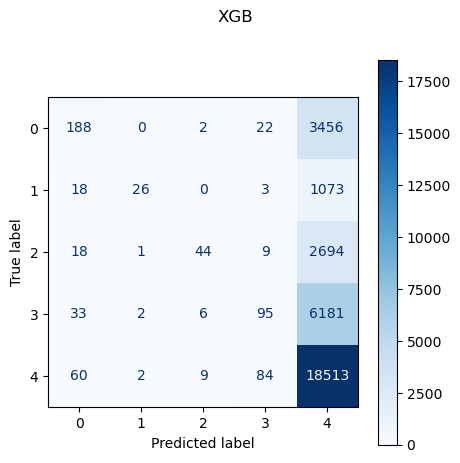

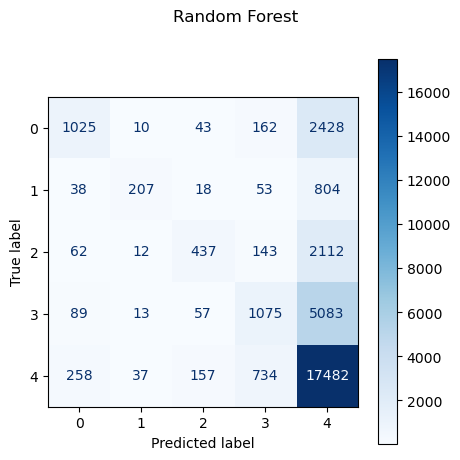

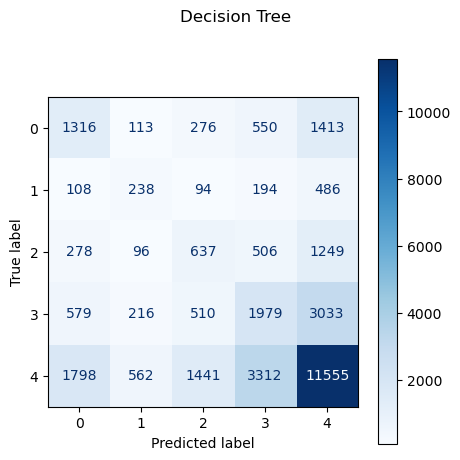

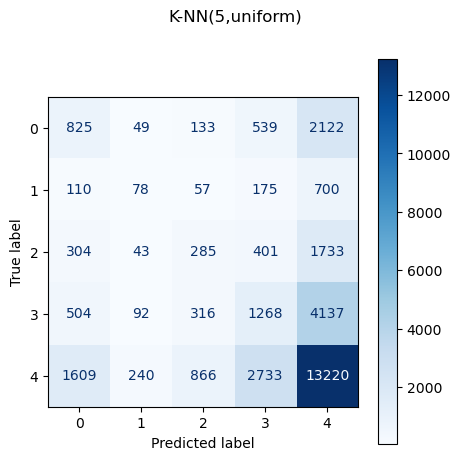

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# fg, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 8))
disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              xgb_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig = disp.figure_
fig.set_figwidth(5)
fig.set_figheight(5) 
fig.suptitle('XGB')


disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              rf_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('Random Forest')


disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              dtc_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('Decision Tree')

disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              knn_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('K-NN(5,uniform)')